# Caso 2 - Avión - Lineal 4 variables estado

Las ecuaciones diferenciales del modelo, solo para pequeños angulos son:

$\dot{\alpha} =a(\phi -\alpha )$

$\ddot{\phi }=-\omega ^{2}(\phi -\alpha -b\cdot u)$

$\dot{h}=c \alpha $



## Representacion espacio de estados

In [60]:
# Importacion de librerias

import numpy as np
import control as ct
import math
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *
import cmath as cm
from math import log
import sympy as sp
from scipy import signal

In [61]:
# x1=alpha x2=phi x3=phi_p x4=h

# Definir los parámetros del sistema
a = 0.07
omega = 9
b = 5
c = 150


# Definir las matrices A, B, C, D del sistema
A = np.array([[-a, a, 0, 0],
              [0, 0, 1, 0],
              [omega**2, -omega**2, 0, 0],
              [c, 0, 0, 0]])

B = np.array([[0], [0], [b * omega**2], [0]])

C = np.array([[0, 0, 0, 1], #
              [0, 1, 0, 0]]) #

#C = np.array([[0, 0, 0, 1]])

D = np.array([[0],[0]])


Los polos a ubicar son $u_i=-15\pm 15j $ ; $-0.5\pm 0.5j$ son 4polos, 2 pares complejos conjugados.


In [62]:
p1=-15+15j
p2 = -15 - 15j
p3 = -0.5 + 0.5j
p4 = -0.5 - 0.5j

poles = np.array([p1, p2, p3, p4])

K=K = ct.acker(A, B, poles)
print("Ganancia K:", K)

# Calcular la matriz Ap del sistema de lazo cerrado
Ap = A - B @ K
print("Matriz Ap del sistema de lazo cerrado:", Ap)
# Crear el sistema de lazo cerrado
sysCL = ct.ss(Ap, B, C, D)
print("Sistema de lazo cerrado:", sysCL)

# Obtener los polos del sistema de lazo cerrado
closed_loop_poles = ct.poles(sysCL)
print("Polos del sistema de lazo cerrado:", closed_loop_poles)

#Calcular la ganancia de prealimentación G
C_out = np.array([[0, 0, 0, 1]])
G = np.linalg.inv(C_out @ np.linalg.inv(Ap) @ B)

print("Ganancia G:", G)
print("Dimensiones de G:", G.shape)  # Confirmar que G es un escalar



Ganancia K: [[15.42104257  0.98107383  0.07637037  0.05291005]]
Matriz Ap del sistema de lazo cerrado: [[-7.00000000e-02  7.00000000e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-6.16452224e+03 -4.78334900e+02 -3.09300000e+01 -2.14285714e+01]
 [ 1.50000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Sistema de lazo cerrado: <StateSpace>: sys[8]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-7.00000000e-02  7.00000000e-02  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [-6.16452224e+03 -4.78334900e+02 -3.09300000e+01 -2.14285714e+01]
     [ 1.50000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[  0.]
     [  0.]
     [405.]
     [  0.]]

C = [[0. 0. 0. 1.]
     [0. 1. 0. 0.]]

D = [[0.]
     [0.]]

Polos del sistema de lazo cerrado: [-15. +15.j  -15. -15.j   -0.5 +0.5j  -0.5 -0.5j]
Ga

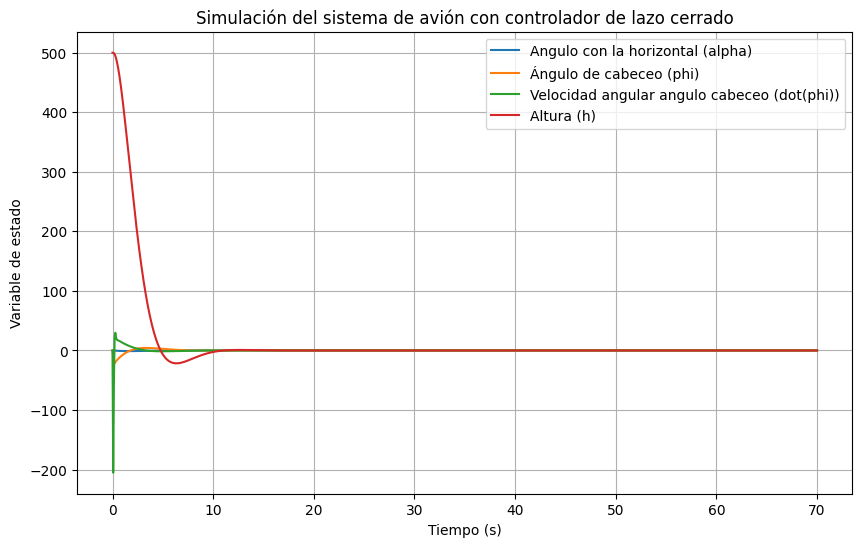

In [63]:
from scipy.integrate import odeint
# Definir la referencia
def reference(t):
    if t < 35:
        return 100
    else:
        return -100
# Definir la función del sistema de espacio de estados
def system(x, t):

    #G=-0.05291005
    r = reference(t)
    u = -K @ x
    #u = -K @ x+G*r
    dxdt = A @ x + B @ u
    return dxdt

# Condiciones iniciales y tiempo de simulación
x0 = np.array([0, 0, 0,500])  # Condiciones iniciales de altura y velocidades
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x = odeint(system, x0, t)

# Gráficos de las variables de estado
plt.figure(figsize=(10, 6))
plt.plot(t, x[:, 0], label='Angulo con la horizontal (alpha)')
plt.plot(t, x[:, 1], label='Ángulo de cabeceo (phi)')
plt.plot(t, x[:, 2], label='Velocidad angular angulo cabeceo (dot(phi))')
plt.plot(t, x[:, 3], label='Altura (h)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Variable de estado')
plt.title('Simulación del sistema de avión con controlador de lazo cerrado')
plt.legend()
plt.grid(True)
plt.show()


## Observador

In [64]:
# Transponer las matrices 
#Ao = np.transpose(A)
#Bo = np.transpose(C)
#Co = np.transpose(B)

#Qo=np.diag([100,10000,100,10000])
#Ro = np.diag([1000000,1000000])
#Ko=ct.lqr(Ao,Bo,Qo,Ro)

ko= [[ 0.0100094127,  0.00355753069, -0.0116816835,  1.73574513],
       [ 0.000120287644, 0.0524230437,  -0.00361958423, 0.00355753069]]

Ko=np.transpose(ko)
#NUEVAMENTE SLYCOT NO FUNCIONA, RESUELVO ESTO EN COLLAB Y OBTENGO Ko

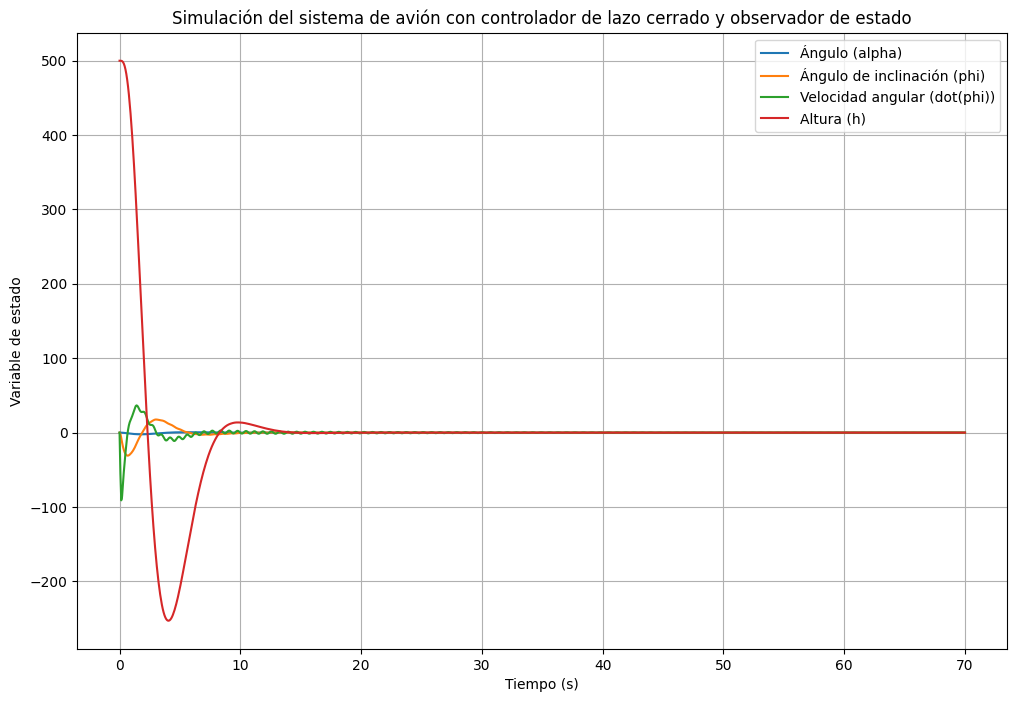

In [65]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Definir la referencia
def reference(t):
    if t < 35:
        return 100
    else:
        return -100

# Definir la función del sistema de espacio de estados con observador
def system_with_observer(x, t):
    x_hat = x[4:]  # Estimaciones del estado (observador)
    x_real = x[:4]  # Estados reales del sistema
    r = reference(t)
    
    u = -K @ x_hat  # Controlador basado en las estimaciones
    
    dx_real = A @ x_real + B @ u  # Dinámica del sistema real
    y = C @ x_real  # Salidas medidas del sistema real
    
    dx_hat = (A - Ko @ C) @ x_hat+ B @ u + Ko @ y  # Dinámica del observador
    
    dxdt = np.hstack((dx_real, dx_hat))  # Combinar dinámicas para odeint
    return dxdt 

# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])  # Condiciones iniciales reales
x0_hat = np.array([0, 0, 0, 0])  # Estimaciones iniciales (observador)
x0 = np.hstack((x0_real, x0_hat))  # Condiciones iniciales combinadas
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x = odeint(system_with_observer, x0, t)

# Gráficos de las variables de estado
plt.figure(figsize=(12, 8))
plt.plot(t, x[:, 0], label='Ángulo (alpha)')
plt.plot(t, x[:, 1], label='Ángulo de inclinación (phi)')
plt.plot(t, x[:, 2], label='Velocidad angular (dot(phi))')
plt.plot(t, x[:, 3], label='Altura (h)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Variable de estado')
plt.title('Simulación del sistema de avión con controlador de lazo cerrado y observador de estado')
plt.legend()
plt.grid(True)
plt.show()


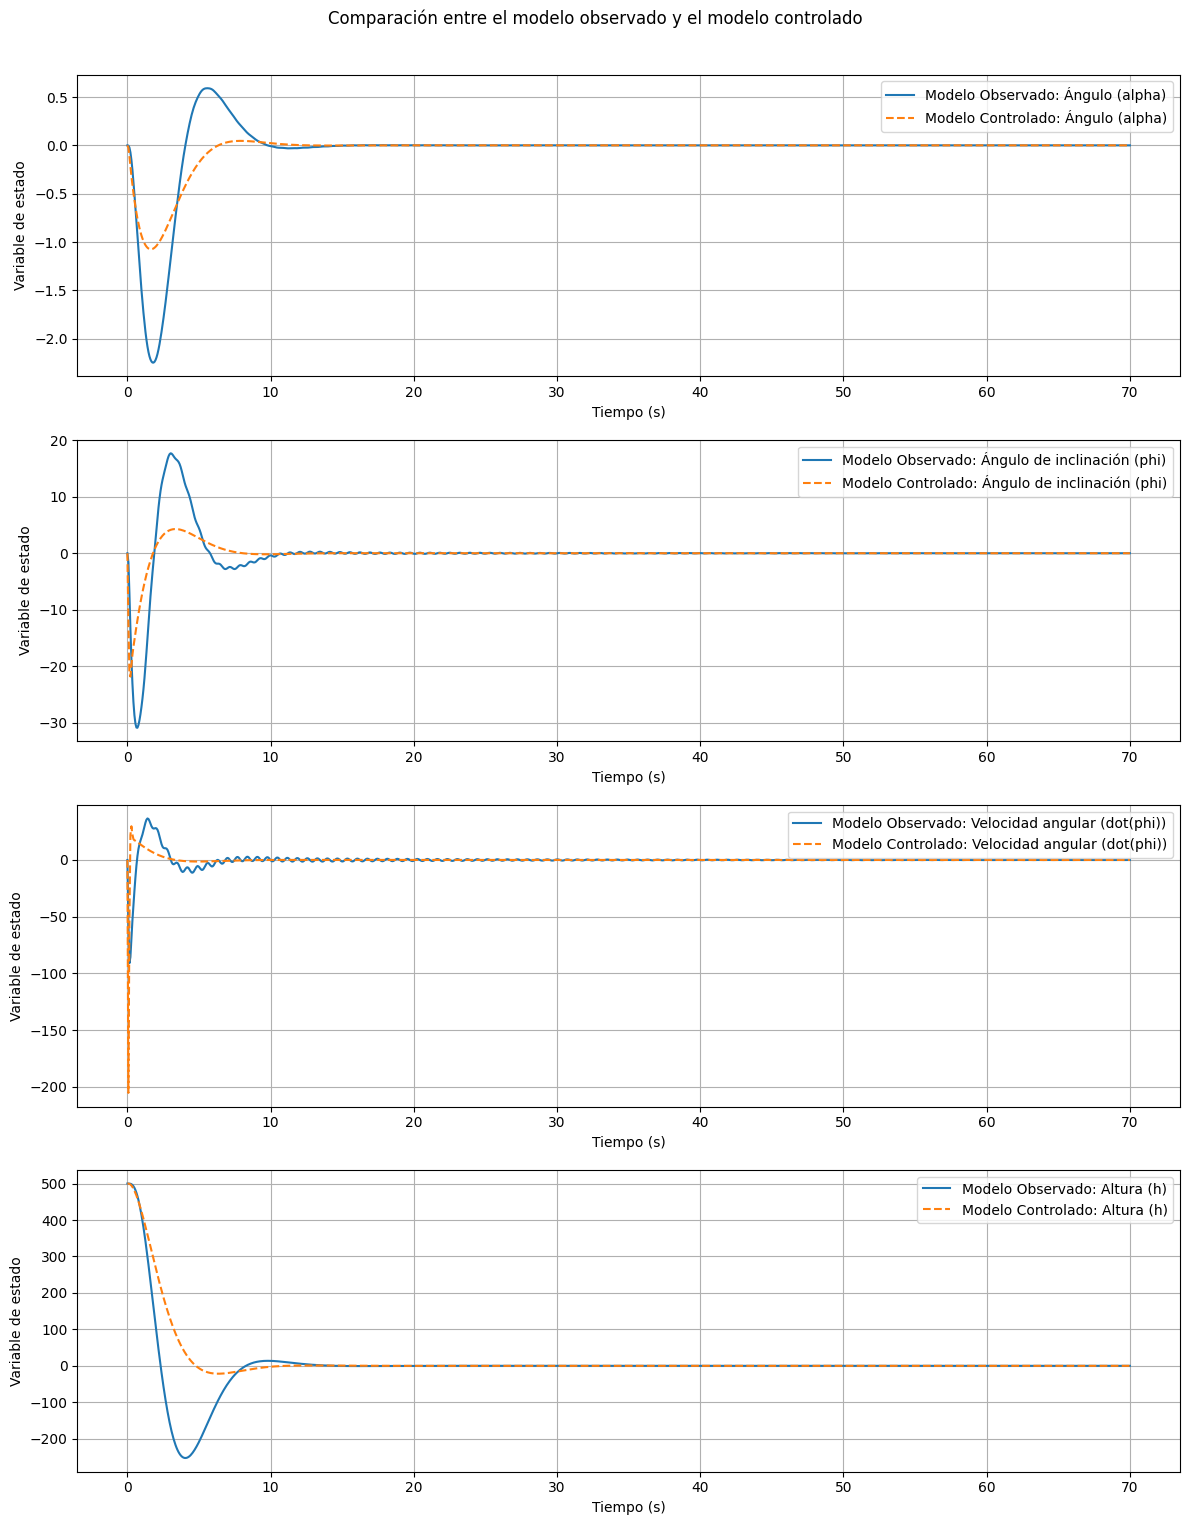

In [66]:
# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])  # Condiciones iniciales reales
x0_hat = np.array([0, 0, 0, 0])  # Estimaciones iniciales (observador)
x0_combined = np.hstack((x0_real, x0_hat))  # Condiciones iniciales combinadas
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x_combined = odeint(system_with_observer, x0_combined, t)
x_controlled = odeint(system, x0_real, t)

# Graficar las variables de estado y compararlas
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

variables = ['Ángulo (alpha)', 'Ángulo de inclinación (phi)', 'Velocidad angular (dot(phi))', 'Altura (h)']

for i in range(4):
    axs[i].plot(t, x_combined[:, i], label=f'Modelo Observado: {variables[i]}')
    axs[i].plot(t, x_controlled[:, i], label=f'Modelo Controlado: {variables[i]}', linestyle='--')
    axs[i].set_xlabel('Tiempo (s)')
    axs[i].set_ylabel('Variable de estado')
    axs[i].legend()
    axs[i].grid(True)

plt.suptitle('Comparación entre el modelo observado y el modelo controlado')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Acción de control Ut

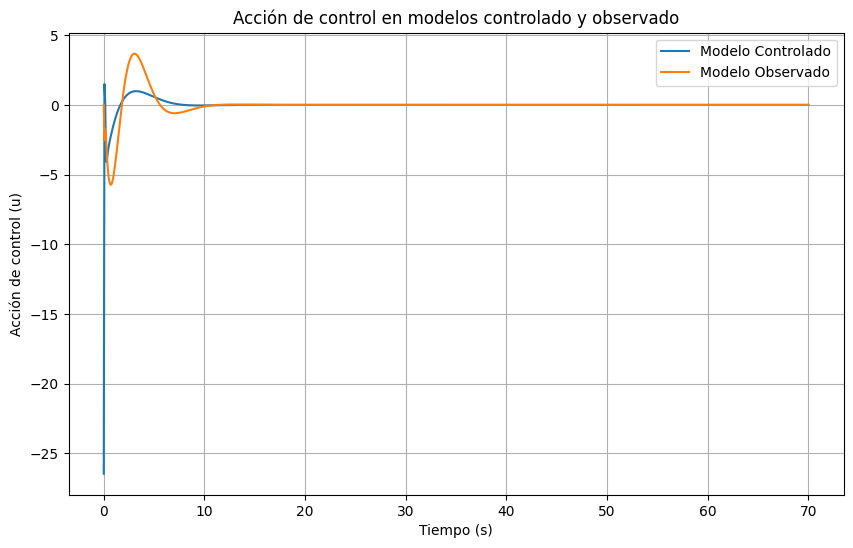

In [78]:
# Definir la función para calcular la acción de control
def control_action(x, t):
    r = reference(t)
    u = -K @ x 
    return u

# Definir la función para calcular la acción de control con observador
def control_action_with_observer(x, t):
    x_hat = x[4:]  # Estimaciones del estado (observador)
    r = reference(t)
    u = -K @ x_hat # Controlador basado en las estimaciones
    return u


# Calcular la acción de control para ambos modelos
u_controlled = np.array([control_action(xi, ti) for xi, ti in zip(x_controlled, t)]).flatten()
u_observer = np.array([control_action_with_observer(xi, ti) for xi, ti in zip(x_combined, t)]).flatten()

# Graficar la acción de control para ambos modelos superpuestos
plt.figure(figsize=(10, 6))
plt.plot(t, u_controlled, label='Modelo Controlado')
plt.plot(t, u_observer, label='Modelo Observado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Acción de control (u)')
plt.title('Acción de control en modelos controlado y observado')
plt.legend()
plt.grid(True)
plt.show()